<a href="https://colab.research.google.com/github/koleshjr/Fake_News_Classification/blob/main/Fake_news_or_real_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FAKE NEWS CLASSIFICATION EDA
* Can you recognize which articles are real and which one is fake? 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, accuracy_score

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image

import spacy
import en_core_web_sm

import random
import warnings
warnings.filterwarnings('ignore')
import time
import datetime

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)


seed_val =42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Loading the Datasets

In [ ]:
path = '/content/gdrive/MyDrive/fake_news_classifier/'
fake = pd.read_csv(path + 'Fake.csv')
true = pd.read_csv(path + 'True.csv')



display( fake.head(), fake.shape,true.head(), true.shape)



,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


(23481, 4)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


(21417, 4)

In [ ]:
fake['target'] =  0
true['target'] = 1
df = pd.concat([fake, true])
df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


Target value_counts

In [ ]:
df['target'].value_counts()

0    23481
1    21417
Name: target, dtype: int64

subject value_counts

In [ ]:
df['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [ ]:

df['inputs'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,target,inputs
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...


### Text Cleaning
* The above dataset already looks clean so no need for cleaning but this is the process you would have used for a dirty dataset

In [ ]:
## Remove URLS, htmls, emojis and punctuations
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

df['inputs'] = df['inputs'].apply(lambda x: remove_URL(x))
df['inputs'] = df['inputs'].apply(lambda x: remove_emoji(x))
df['inputs'] = df['inputs'].apply(lambda x: remove_html(x))
df['inputs'] = df['inputs'].apply(lambda x: remove_punct(x))

In [ ]:
df['inputs'].head()

0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
Name: inputs, dtype: object

Tokenization

In [ ]:
df = df.drop(columns=['title','text','subject'])
df['tokenized'] = df['inputs'].apply(word_tokenize)
df.head()

,date,target,inputs,tokenized
0,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,"[Donald, Trump, Sends, Out, Embarrassing, New,..."
1,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,"[Drunk, Bragging, Trump, Staffer, Started, Rus..."
2,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,"[Sheriff, David, Clarke, Becomes, An, Internet..."
3,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,"[Trump, Is, So, Obsessed, He, Even, Has, Obama..."
4,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,"[Pope, Francis, Just, Called, Out, Donald, Tru..."


Lower casing the tokens

In [ ]:
df['lower'] = df['tokenized'].apply(
    lambda x: [word.lower() for word in x]
)
df.head()

,date,target,inputs,tokenized,lower
0,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,"[Donald, Trump, Sends, Out, Embarrassing, New,...","[donald, trump, sends, out, embarrassing, new,..."
1,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,"[Drunk, Bragging, Trump, Staffer, Started, Rus...","[drunk, bragging, trump, staffer, started, rus..."
2,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,"[Sheriff, David, Clarke, Becomes, An, Internet...","[sheriff, david, clarke, becomes, an, internet..."
3,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,"[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[trump, is, so, obsessed, he, even, has, obama..."
4,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,"[Pope, Francis, Just, Called, Out, Donald, Tru...","[pope, francis, just, called, out, donald, tru..."


Removing Stop words

In [ ]:
df['stops_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop]
)

Part of speech tags

In [ ]:
df['pos_tags'] = df['stops_removed'].apply(nltk.tag.pos_tag)
df.head()

,date,target,inputs,tokenized,lower,stops_removed,pos_tags
0,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,"[Donald, Trump, Sends, Out, Embarrassing, New,...","[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, embarrassing, new, year...","[(donald, JJ), (trump, NN), (sends, NNS), (emb..."
1,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,"[Drunk, Bragging, Trump, Staffer, Started, Rus...","[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus...","[(drunk, NN), (bragging, VBG), (trump, NN), (s..."
2,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,"[Sheriff, David, Clarke, Becomes, An, Internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, internet, jo...","[(sheriff, NN), (david, NN), (clarke, NN), (be..."
3,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,"[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[trump, is, so, obsessed, he, even, has, obama...","[trump, obsessed, even, obama, ’, name, coded,...","[(trump, NN), (obsessed, VBD), (even, RB), (ob..."
4,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,"[Pope, Francis, Just, Called, Out, Donald, Tru...","[pope, francis, just, called, out, donald, tru...","[pope, francis, called, donald, trump, christm...","[(pope, NN), (francis, NN), (called, VBN), (do..."


Convert part of speech to wordnet format

In [ ]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


df['wordnet_pos'] = df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

df.head()

,date,target,inputs,tokenized,lower,stops_removed,pos_tags,wordnet_pos
0,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,"[Donald, Trump, Sends, Out, Embarrassing, New,...","[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, embarrassing, new, year...","[(donald, JJ), (trump, NN), (sends, NNS), (emb...","[(donald, a), (trump, n), (sends, n), (embarra..."
1,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,"[Drunk, Bragging, Trump, Staffer, Started, Rus...","[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus...","[(drunk, NN), (bragging, VBG), (trump, NN), (s...","[(drunk, n), (bragging, v), (trump, n), (staff..."
2,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,"[Sheriff, David, Clarke, Becomes, An, Internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, internet, jo...","[(sheriff, NN), (david, NN), (clarke, NN), (be...","[(sheriff, n), (david, n), (clarke, n), (becom..."
3,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,"[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[trump, is, so, obsessed, he, even, has, obama...","[trump, obsessed, even, obama, ’, name, coded,...","[(trump, NN), (obsessed, VBD), (even, RB), (ob...","[(trump, n), (obsessed, v), (even, r), (obama,..."
4,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,"[Pope, Francis, Just, Called, Out, Donald, Tru...","[pope, francis, just, called, out, donald, tru...","[pope, francis, called, donald, trump, christm...","[(pope, NN), (francis, NN), (called, VBN), (do...","[(pope, n), (francis, n), (called, v), (donald..."


Word lemmatizer

In [ ]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

df.head()

,date,target,inputs,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,"[Donald, Trump, Sends, Out, Embarrassing, New,...","[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, embarrassing, new, year...","[(donald, JJ), (trump, NN), (sends, NNS), (emb...","[(donald, a), (trump, n), (sends, n), (embarra...","[donald, trump, sends, embarrass, new, year, ’...",donald trump sends embarrass new year ’ eve me...
1,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,"[Drunk, Bragging, Trump, Staffer, Started, Rus...","[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus...","[(drunk, NN), (bragging, VBG), (trump, NN), (s...","[(drunk, n), (bragging, v), (trump, n), (staff...","[drunk, brag, trump, staffer, start, russian, ...",drunk brag trump staffer start russian collusi...
2,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,"[Sheriff, David, Clarke, Becomes, An, Internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, internet, jo...","[(sheriff, NN), (david, NN), (clarke, NN), (be...","[(sheriff, n), (david, n), (clarke, n), (becom...","[sheriff, david, clarke, become, internet, jok...",sheriff david clarke become internet joke thre...
3,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,"[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[trump, is, so, obsessed, he, even, has, obama...","[trump, obsessed, even, obama, ’, name, coded,...","[(trump, NN), (obsessed, VBD), (even, RB), (ob...","[(trump, n), (obsessed, v), (even, r), (obama,...","[trump, obsess, even, obama, ’, name, cod, web...",trump obsess even obama ’ name cod website ima...
4,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,"[Pope, Francis, Just, Called, Out, Donald, Tru...","[pope, francis, just, called, out, donald, tru...","[pope, francis, called, donald, trump, christm...","[(pope, NN), (francis, NN), (called, VBN), (do...","[(pope, n), (francis, n), (called, v), (donald...","[pope, francis, call, donald, trump, christmas...",pope francis call donald trump christmas speec...


### Data Visualization

#### Target Visualization

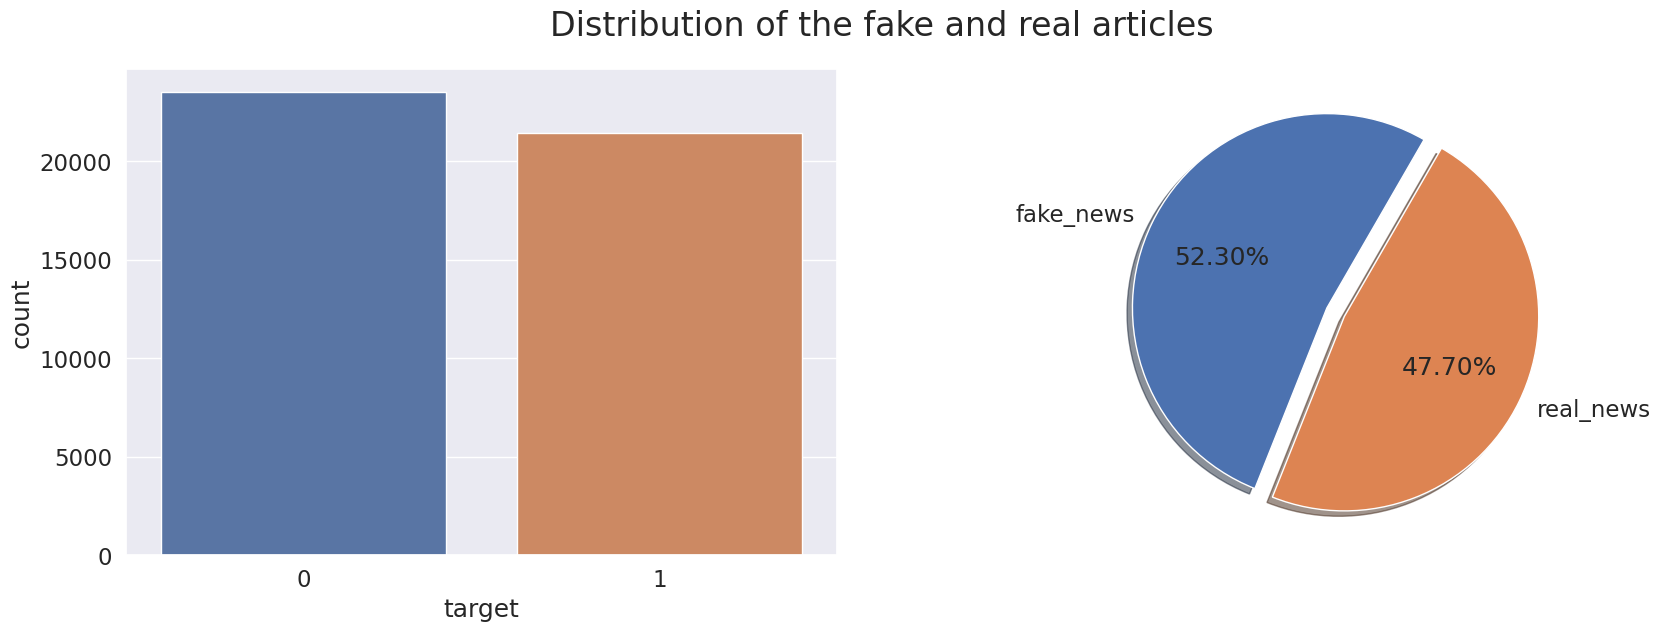

In [ ]:


# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(df['target'], ax=axes[0])
axes[1].pie(df['target'].value_counts(),
            labels=['fake_news', 'real_news'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0.05),
            startangle=60)
fig.suptitle('Distribution of the fake and real articles', fontsize=24)
plt.show()



#### Inputs Lengths

In [ ]:
df.head()

,date,target,inputs,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,"[Donald, Trump, Sends, Out, Embarrassing, New,...","[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, embarrassing, new, year...","[(donald, JJ), (trump, NN), (sends, NNS), (emb...","[(donald, a), (trump, n), (sends, n), (embarra...","[donald, trump, sends, embarrass, new, year, ’...",donald trump sends embarrass new year ’ eve me...
1,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,"[Drunk, Bragging, Trump, Staffer, Started, Rus...","[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus...","[(drunk, NN), (bragging, VBG), (trump, NN), (s...","[(drunk, n), (bragging, v), (trump, n), (staff...","[drunk, brag, trump, staffer, start, russian, ...",drunk brag trump staffer start russian collusi...
2,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,"[Sheriff, David, Clarke, Becomes, An, Internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, internet, jo...","[(sheriff, NN), (david, NN), (clarke, NN), (be...","[(sheriff, n), (david, n), (clarke, n), (becom...","[sheriff, david, clarke, become, internet, jok...",sheriff david clarke become internet joke thre...
3,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,"[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[trump, is, so, obsessed, he, even, has, obama...","[trump, obsessed, even, obama, ’, name, coded,...","[(trump, NN), (obsessed, VBD), (even, RB), (ob...","[(trump, n), (obsessed, v), (even, r), (obama,...","[trump, obsess, even, obama, ’, name, cod, web...",trump obsess even obama ’ name cod website ima...
4,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,"[Pope, Francis, Just, Called, Out, Donald, Tru...","[pope, francis, just, called, out, donald, tru...","[pope, francis, called, donald, trump, christm...","[(pope, NN), (francis, NN), (called, VBN), (do...","[(pope, n), (francis, n), (called, v), (donald...","[pope, francis, call, donald, trump, christmas...",pope francis call donald trump christmas speec...


In [ ]:
# Creating a new feature for the visualization.

df['Character Count'] = df['inputs'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

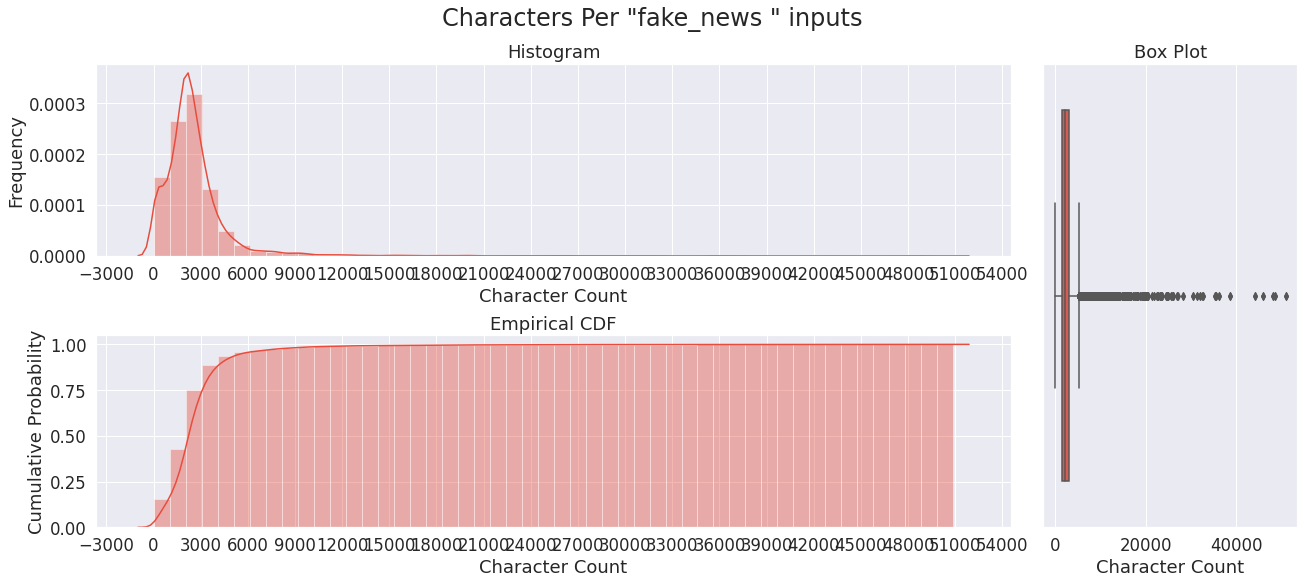

In [ ]:
plot_dist3(df[df['target'] == 0], 'Character Count',
           'Characters Per "fake_news " inputs')

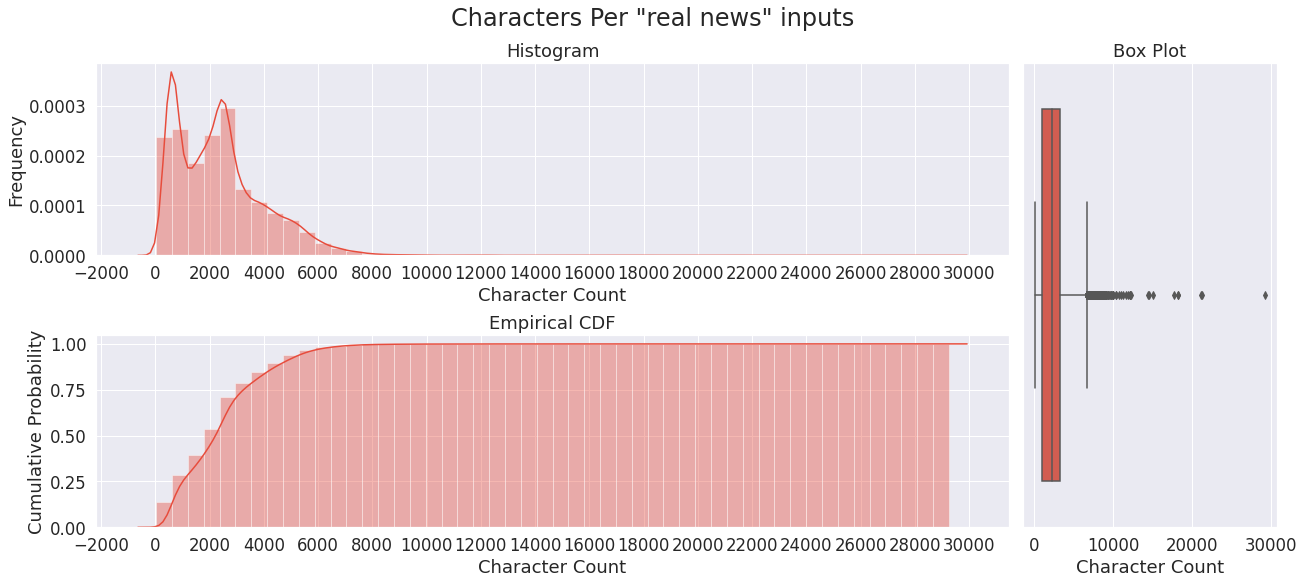

In [ ]:
plot_dist3(df[df['target'] == 1], 'Character Count',
           'Characters Per "real news" inputs')

#### Word Count

In [ ]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    # sns.distplot(textun.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Fake News')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Real News')
    # axes[2].set_xlabel('Word Count')
    # axes[2].set_title('-1')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

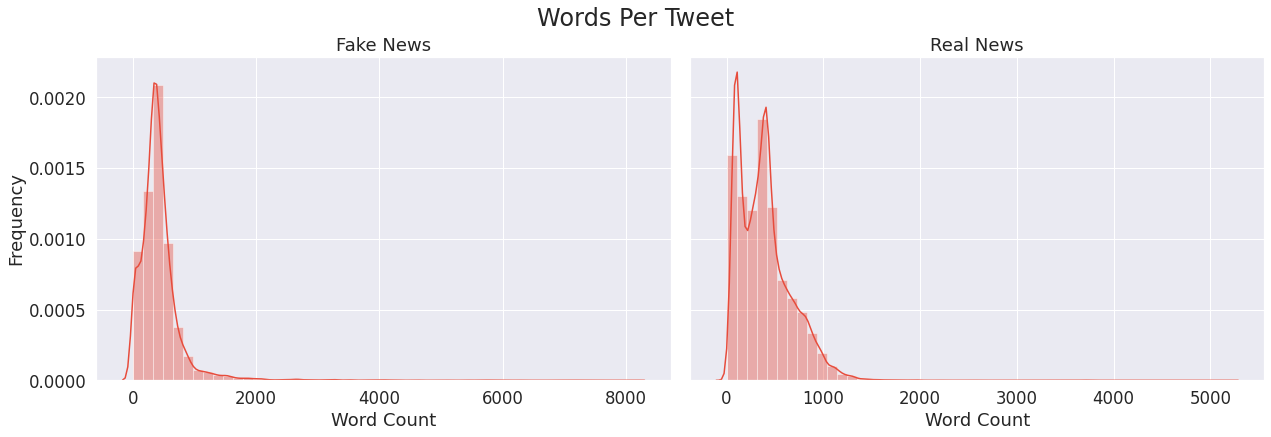

In [ ]:
plot_word_number_histogram(df[df['target'] == 0]['inputs'],
                           df[df['target'] == 1]['inputs'],
                           )

#### Word length

In [ ]:
def plot_word_len_histogram(textno, textye):

  ''' arguments represent the number of classes present. This function is used to calculate average word lengths'''
  
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
  sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
      lambda x: np.mean(x)),
                ax=axes[0], color='#e74c3c')
  sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
      lambda x: np.mean(x)),
                ax=axes[1], color='#e74c3c')
  # sns.distplot(textna.str.split().apply(lambda x: [len(i) for i in x]).map(
  #     lambda x: np.mean(x)),
  #              ax=axes[2], color='#e74c3c')
  
  axes[0].set_xlabel('Word Length')
  axes[0].set_ylabel('Frequency')

  axes[0].set_title('Fake News')
  axes[1].set_xlabel('Word Length')
  axes[1].set_title('Real News')
  # axes[2].set_xlabel('Word Length')
  # axes[2].set_title('-1')
  
  fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
  fig.tight_layout()

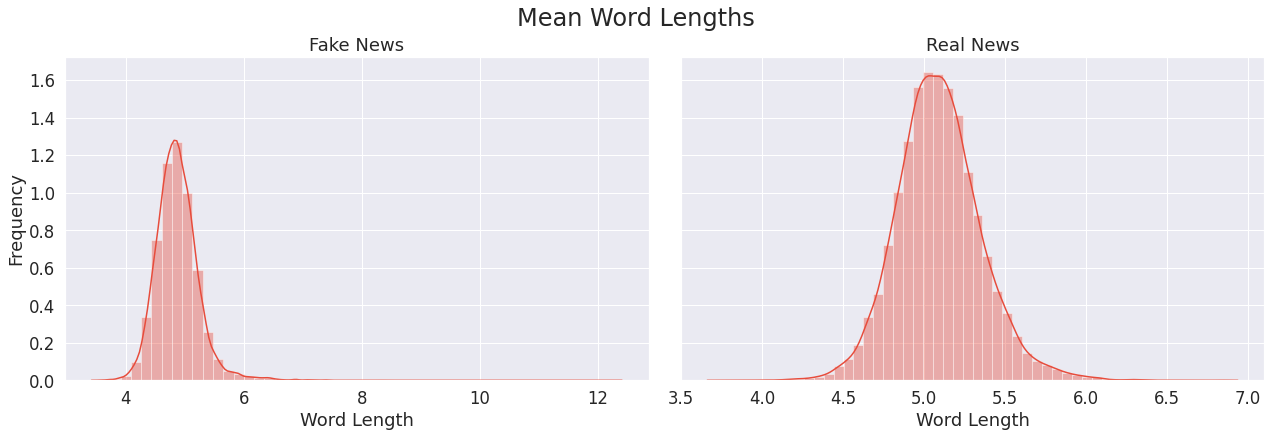

In [ ]:
plot_word_len_histogram(df[df['target'] == 0]['inputs'],
                           df[df['target'] == 1]['inputs'],)

#### Most Common Words

In [ ]:
df.head()

,date,target,inputs,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str,Character Count
0,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,"[Donald, Trump, Sends, Out, Embarrassing, New,...","[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, embarrassing, new, year...","[(donald, JJ), (trump, NN), (sends, NNS), (emb...","[(donald, a), (trump, n), (sends, n), (embarra...","[donald, trump, sends, embarrass, new, year, ’...",donald trump sends embarrass new year ’ eve me...,2851
1,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,"[Drunk, Bragging, Trump, Staffer, Started, Rus...","[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus...","[(drunk, NN), (bragging, VBG), (trump, NN), (s...","[(drunk, n), (bragging, v), (trump, n), (staff...","[drunk, brag, trump, staffer, start, russian, ...",drunk brag trump staffer start russian collusi...,1929
2,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,"[Sheriff, David, Clarke, Becomes, An, Internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, internet, jo...","[(sheriff, NN), (david, NN), (clarke, NN), (be...","[(sheriff, n), (david, n), (clarke, n), (becom...","[sheriff, david, clarke, become, internet, jok...",sheriff david clarke become internet joke thre...,3522
3,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,"[Trump, Is, So, Obsessed, He, Even, Has, Obama...","[trump, is, so, obsessed, he, even, has, obama...","[trump, obsessed, even, obama, ’, name, coded,...","[(trump, NN), (obsessed, VBD), (even, RB), (ob...","[(trump, n), (obsessed, v), (even, r), (obama,...","[trump, obsess, even, obama, ’, name, cod, web...",trump obsess even obama ’ name cod website ima...,2661
4,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,"[Pope, Francis, Just, Called, Out, Donald, Tru...","[pope, francis, just, called, out, donald, tru...","[pope, francis, called, donald, trump, christm...","[(pope, NN), (francis, NN), (called, VBN), (do...","[(pope, n), (francis, n), (called, v), (donald...","[pope, francis, call, donald, trump, christmas...",pope francis call donald trump christmas speec...,2377


In [ ]:
lis = [
df[df['target'] == 0]['lemma_str'],
df[df['target'] == 1]['lemma_str'],
# train[train['target'] == -1]['lemma_str']
]


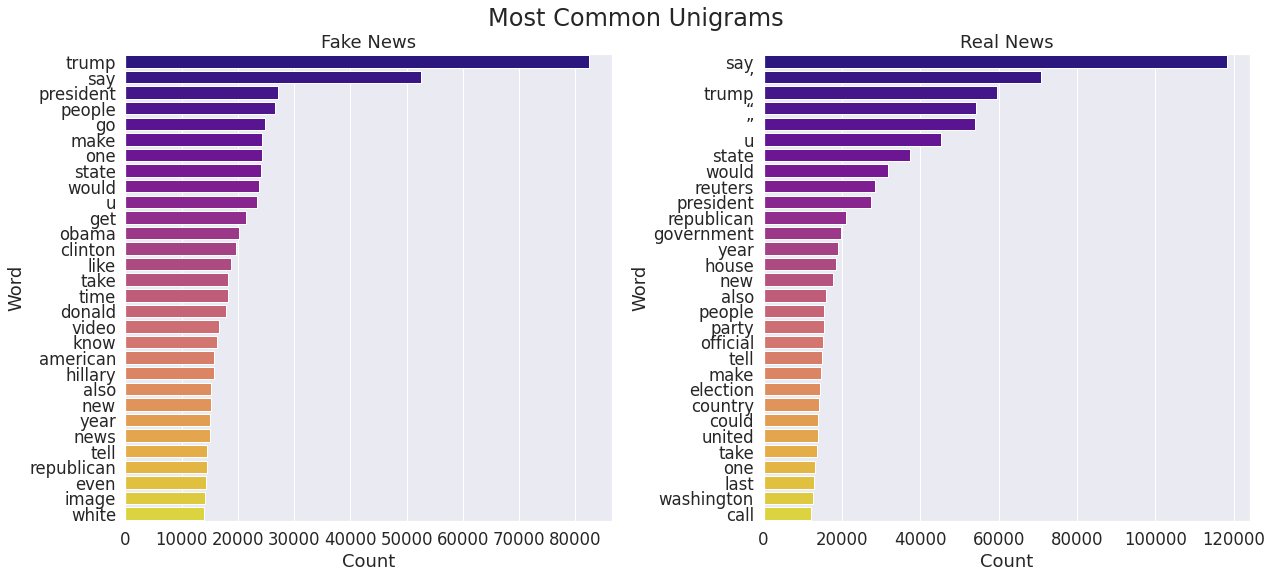

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Fake News')
axes[1].set_title('Real News')
# axes[2].set_title('Label -1')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')
# axes[2].set_xlabel('Count')
# axes[2].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

#### Most Common Bigrams

In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
            for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Fake News')
        axes[1].set_title('Real News')
        # axes[2].set_title('Label -1')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        # axes[2].set_xlabel('Count')
        # axes[2].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

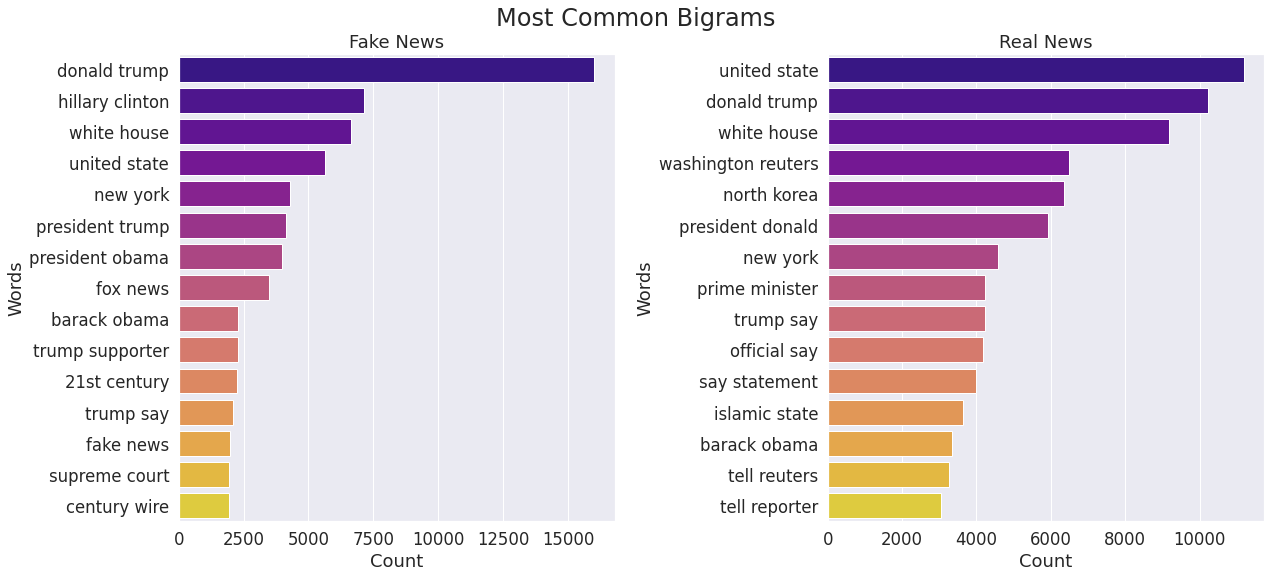

In [ ]:
ngrams(2, 'Most Common Bigrams')

### Most comming trigrams

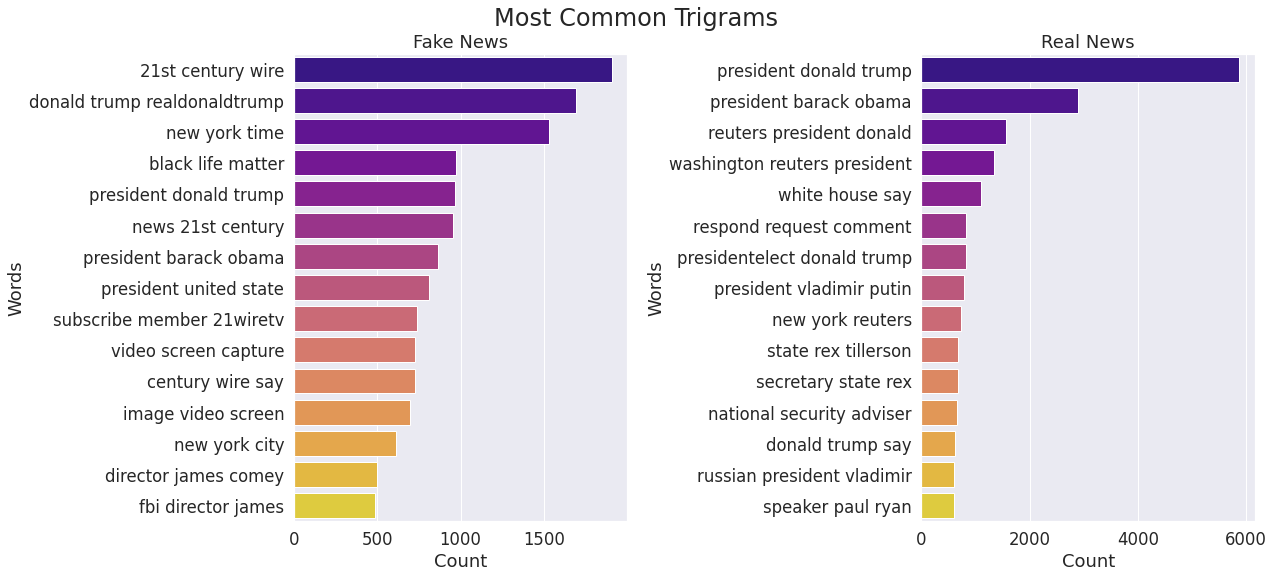

In [ ]:
ngrams(3, 'Most Common Trigrams')

### Word Cloud

In [ ]:
from google.colab import files
uploaded = files.upload()

mask = np.array(Image.open('twitter.jpeg'))
mask[mask.sum(axis=2) == 0] = 128

Saving twitter.jpeg to twitter.jpeg


In [ ]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='grey',
    ).generate(str(mostcommon))    

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()


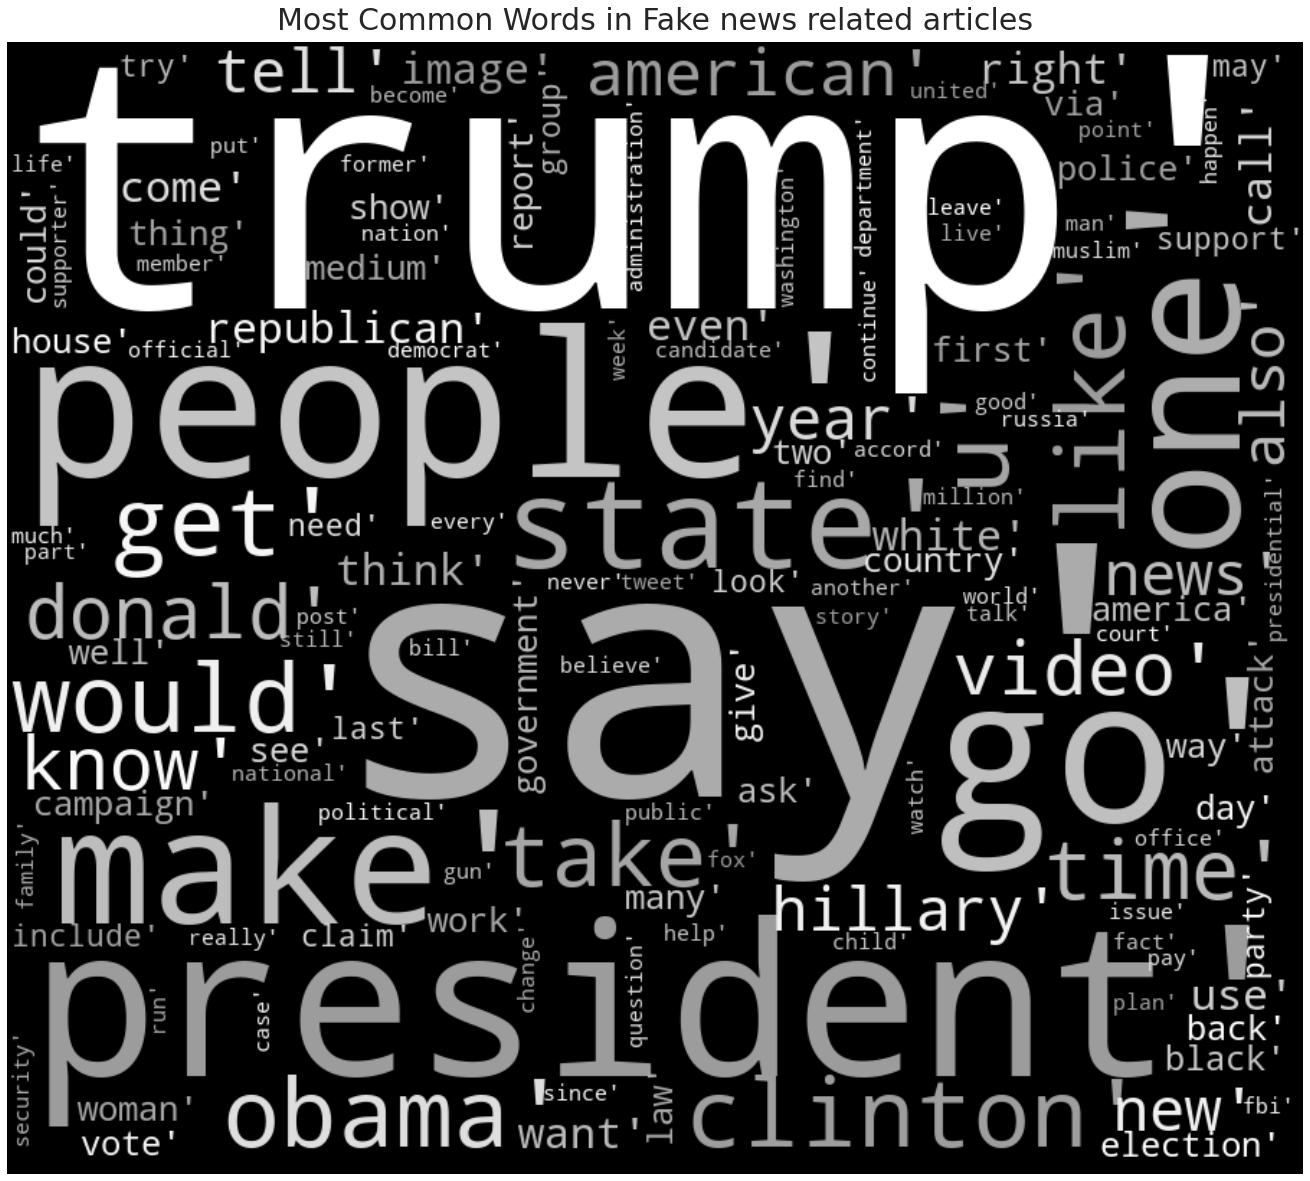

In [ ]:


plot_wordcloud(df[df['target'] == 0]['lemmatized'],
               'Most Common Words in Fake news related articles',
               title_size=30)



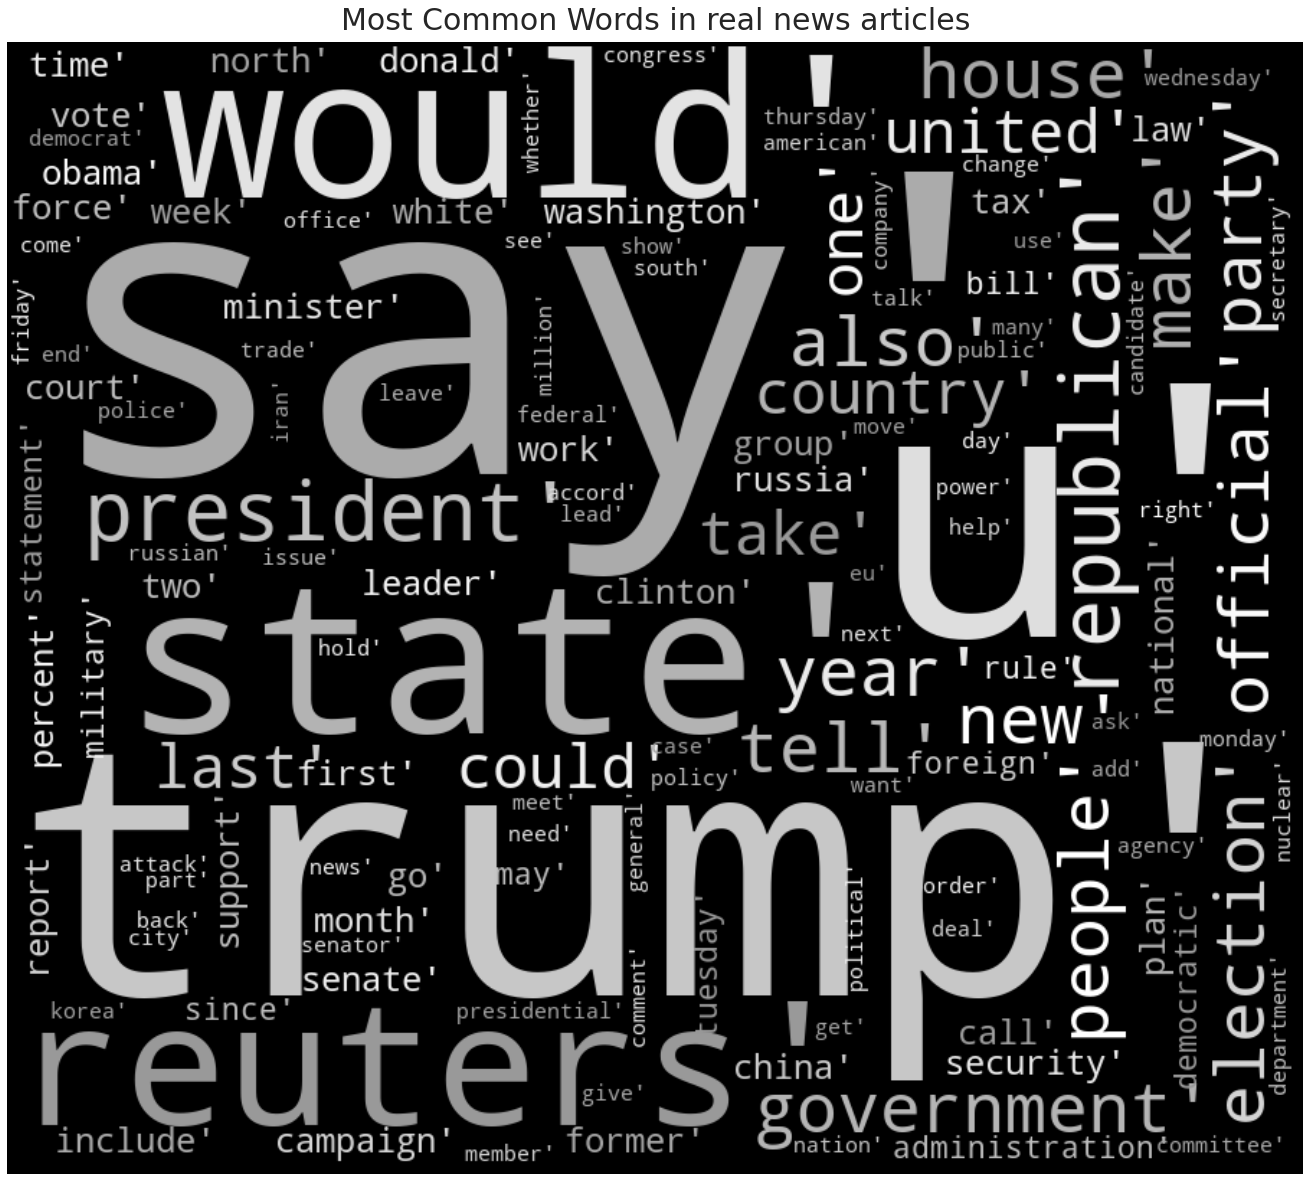

In [ ]:


plot_wordcloud(df[df['target'] == 1]['lemmatized'],
               'Most Common Words in real news articles',
               title_size=30)



In [ ]:


# plot_wordcloud(train[train['target'] == -1]['lemmatized'],
#                'Most Common Words in label -1',
#                title_size=30)



#### Named Entity Recognition

In [ ]:
# Loading NER.
nlp = en_core_web_sm.load() 

In [ ]:
def plot_named_entity_barchart(text):
    
    """A function for extracting named entities and comparing them"""
    
    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

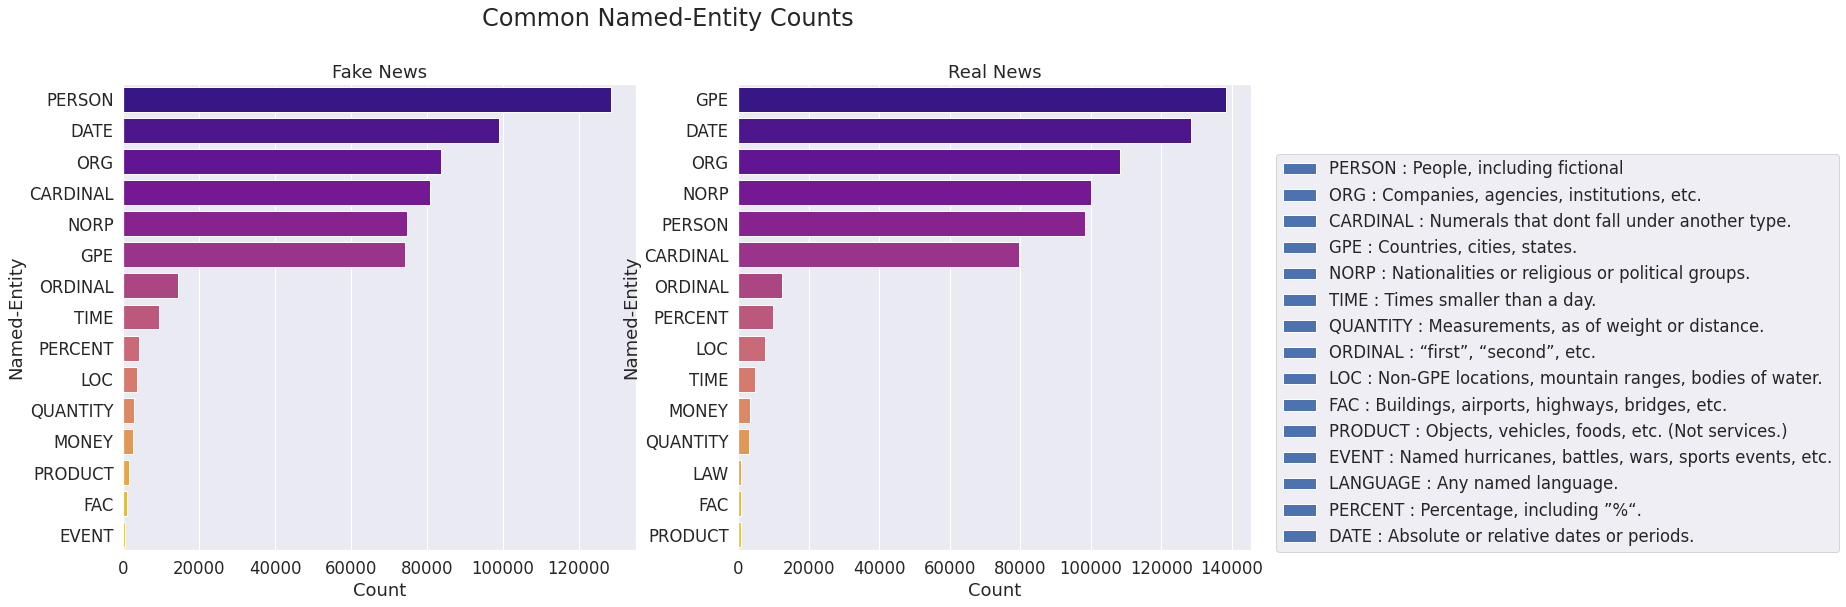

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Fake News')
axes[1].set_title('Real News')
# axes[2].set_title('Label 2')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
# axes[2].set_xlabel('Count')
# axes[2].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()